# Image comparison
- Size
- Channels (RGB / grayscale)

## Libraries

### General Purposes

In [1]:
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
from itertools import cycle
from time import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Tensorflow

In [2]:
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.utils import to_categorical

C:\Users\leohe\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Functions

In [3]:
def resampling(src, r=2):
    """
    Resamples an image n times using the pyrDown function from opencv
    :param src: np.array - image
    :param n: scalar - times
    :return src: np.array - processed image
    """
    for _ in range(r):
        src = cv2.pyrDown(src)
    return src

def load_folders(filedir, n=2, resample=False, r=1/2, color=False):
    """
    Loads the data from n folders, with(out) resampling
    :param filedir: str - folder with all images
    :param n: scalar - number of folder
    :param resample: bool - flag for resampling
    :param r: scalar - number of resamples
    :param color: bool - read color images
    :return stacked: data - images
    :return label: data - label
    """
    folder_list = [folder for folder in os.listdir(filedir)]
    if color:
        stacked  = np.empty((n * 3000, int(200 / (2 * r)), int(200 / (2 * r)), 3), dtype='uint8')
        color_str = "on BGR"
    else:
        stacked  = np.empty((n * 3000, int(200 / (2 * r)), int(200 / (2 * r))), dtype='uint8')
        color_str = "on Grayscale"
    label = np.empty((n * 3000, 1), 
                     dtype='uint8')
    count = 0
    start = time()
    for folder in folder_list[:n]:
        subfolder = FILEDIR + '\\' + folder
        file_list = [file for file in os.listdir(subfolder)]
        print("Startting folder {} at {}".format(folder, datetime.now()))
        for file in file_list:
            if color:
                img = cv2.imread(subfolder + '\\' + file)
            else:
                img = cv2.imread(subfolder + '\\' + file, 0)
            resample_str = "without resamples"
            if resample:
                resample_str = "with {} resamples".format(r)
                img = resampling(img, r)
            stacked[count] = img.astype('int8')
            label[count] = LABEL[folder]
            count += 1
    print(u"There were {} files, collected from {} folders, {}, {}.\nExecution Time: \u2248 {:.2f} [min]"
          .format(count, n, color_str, resample_str, (time() - start) / 60))
    return stacked, label


def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    classes = np.arange(0, cm.shape[0])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## Constants

In [4]:
LABEL = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
         'K':10, 'L':11, 'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19,
         'U':20, 'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25, 
         'del':26, 'nothing':27, 'space':28}

FILEDIR = r'C:\Users\leohe\Documents\ITC\HIVE\Challenge\asl_alphabet_train'

In [5]:
stacked, label = load_folders(FILEDIR, n=4)

Startting folder A at 2018-06-26 19:10:16.408118
Startting folder B at 2018-06-26 19:10:27.440938
Startting folder C at 2018-06-26 19:10:49.704468
Startting folder D at 2018-06-26 19:11:11.184537
There were 12000 files, collected from 4 folders, on Grayscale, without resamples.
Execution Time: ≈ 1.26 [min]


In [ ]:
# stacked = np.load('ASL_x_gray.npy')
# label = np.load()

In [6]:
stacked, label = shuffle(stacked, label)
x_train, x_test, y_train, y_test = train_test_split(stacked, label, test_size=0.2, )

In [7]:
inputs = layers.Input(shape=x_train.shape[1:])
f = layers.Conv1D(64, (5))(inputs)
f = layers.BatchNormalization()(f)
f = layers.Conv1D(32, (5), activation='relu')(f)
f = layers.BatchNormalization()(f)
f = layers.MaxPool1D()(f)
f = layers.Conv1D(16, (5), activation='relu')(f)
f = layers.BatchNormalization()(f)
f = layers.Conv1D( 8, (5), activation='relu')(f)
f = layers.BatchNormalization()(f)
f = layers.MaxPool1D()(f)
f = layers.Flatten()(f)
f = layers.Dense(400, activation='relu')(f)
f = layers.Dense(200, activation='relu')(f)
f = layers.Dense(100, activation='relu')(f)
f = layers.Dense(100, activation='relu')(f)
f = layers.Dense( 50, activation='relu')(f)
outputs = layers.Dense(len(np.unique(y_train)), activation='softmax')(f)
model = Model(inputs=inputs, outputs=outputs)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           64064     
_________________________________________________________________
batch_normalization_1 (Batch (None, 196, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 192, 32)           10272     
_________________________________________________________________
batch_normalization_2 (Batch (None, 192, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 92, 16)            2576      
__________

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train / np.max(x_train), 
                    y=to_categorical(y_train, len(np.unique(y_train))), 
                    batch_size=128, epochs=20, 
                    validation_split=0.2)

Train on 7680 samples, validate on 1920 samples
Epoch 1/20
7680/7680 [==============================] - 254s 33ms/step - loss: 0.6973 - acc: 0.7052 - val_loss: 3.2443 - val_acc: 0.4177
Epoch 2/20
7680/7680 [==============================] - 27s 4ms/step - loss: 0.2213 - acc: 0.9206 - val_loss: 2.9512 - val_acc: 0.5130
Epoch 3/20
7680/7680 [==============================] - 26s 3ms/step - loss: 0.1170 - acc: 0.9578 - val_loss: 1.4059 - val_acc: 0.6656
Epoch 4/20
7680/7680 [==============================] - 26s 3ms/step - loss: 0.0923 - acc: 0.9660 - val_loss: 0.6681 - val_acc: 0.7943
Epoch 5/20
7680/7680 [==============================] - 26s 3ms/step - loss: 0.0619 - acc: 0.9781 - val_loss: 0.2075 - val_acc: 0.9297
Epoch 6/20
7680/7680 [==============================] - 28s 4ms/step - loss: 0.0565 - acc: 0.9790 - val_loss: 0.2108 - val_acc: 0.9245
Epoch 7/20
7680/7680 [==============================] - 27s 4ms/step - loss: 0.0508 - acc: 0.9822 - val_loss: 0.2085 - val_acc: 0.9156
Epoch

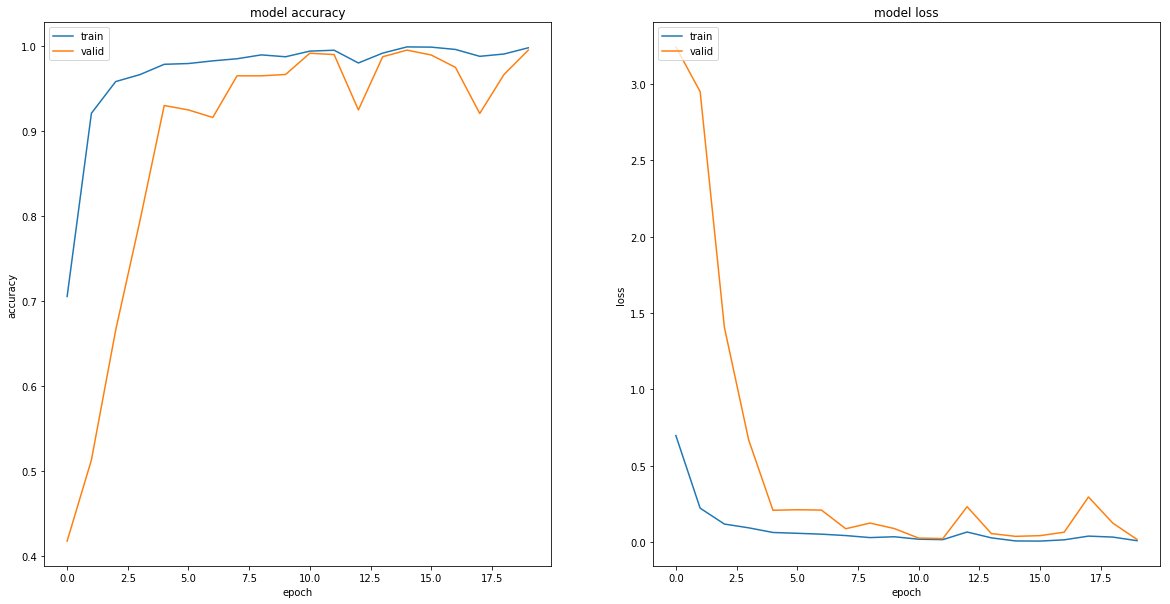

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

2400/2400 [==============================] - 4s 2ms/step
Test Set	Loss : 0.016280		Accuracy :  99.33%
[[583   1   1   0]
 [  0 611   0   0]
 [  2   0 582   0]
 [ 11   1   0 608]]


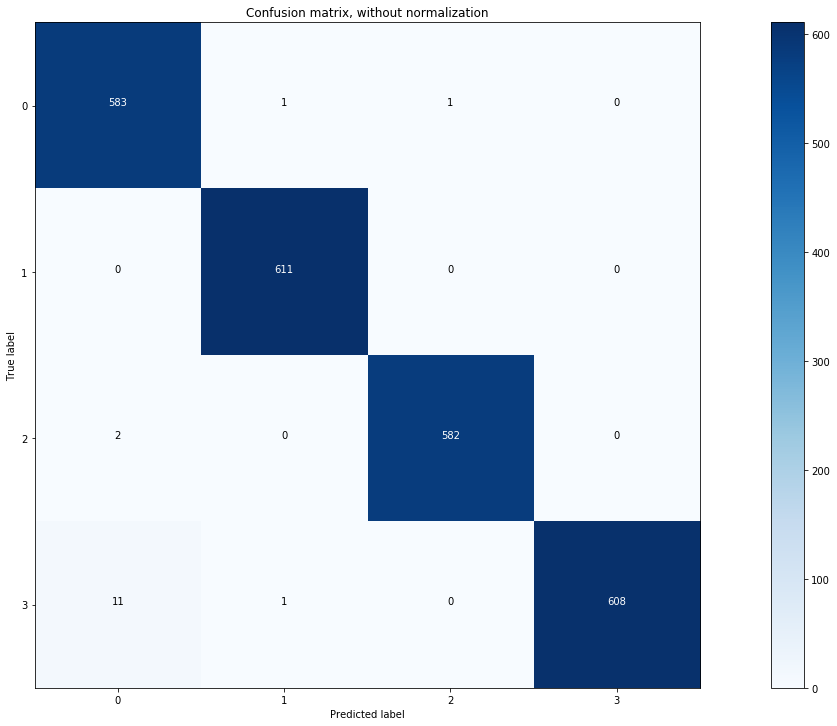

In [10]:
loss, acc = model.evaluate(x=x_test / np.max(x_test), y=to_categorical(y_test, len(np.unique(y_test))))
print("Test Set\tLoss : {:2f}\t\tAccuracy : {:6.2f}%".format(loss, 100 * acc))
targets = np.argmax(to_categorical(y_test, len(np.unique(y_test))), axis=-1)
probabilities = model.predict(x=x_test / np.max(x_test))
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
print(cm)
plot_confusion_matrix(cm)